# Regressão Logística I
Vamos trabalhar com a mesma base anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [120]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from scipy.stats import ks_2samp

import statsmodels.formula.api as smf

In [121]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [122]:
# Visualizando informações para planejar a análise
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


1. Criando uma função que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Montando** a mesma bivariada com pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [123]:
# Criando uma função para analise bivariada
def analise_bivariada(data, variavel_resposta, variavel_explicativa):
    
    # Criando a tabela de contingência
    tab = pd.crosstab(data[variavel_explicativa], data[variavel_resposta], margins=True)
    
    # Calculando a média da variável resposta para cada grupo da variável explicativa
    tab['media_' + variavel_resposta] = tab[1] / tab['All']
    
    # Calculando Odds
    tab['odds'] = tab[1] / tab[0]
    
    # Calculando o odds ratio com o total como referência
    tab['RC_total'] = tab['odds'] / tab.loc['All', 'odds']
    
    # Calculando o logito (LOG(Odds))
    tab['logito'] = np.log(tab['odds'])
    
    # Calculando Log do odds ratio (WOE)
    tab['woe'] = np.log(tab['RC_total'])
    
    return tab

#### Criando uma função que calcula a acurácia, o AUC, o Gini e o KS

In [124]:
# Criando uma função que avalia o modelo com AUC, Gini e KS
def avaliar_modelo(y_true, y_pred_prob):
    
    # Acurácia
    acc = metrics.accuracy_score(y_true, y_pred_prob > 0.5)
    print('Acurácia: {0:.2f}%'.format(acc * 100))

    # AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_prob)
    auc_ = metrics.auc(fpr, tpr)

    # Gini
    gini = 2 * auc_ - 1

    # KS
    ks = ks_2samp(y_pred_prob[y_true == 1], y_pred_prob[y_true != 1]).statistic

    print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
          .format(ks * 100, auc_ * 100, gini * 100))

In [125]:
# Fazendo análise bivariada com os atributos da função 'analise_bivariada'
analise_bivariada(df, 'flag_doente', 'cp')

flag_doente,0,1,All,media_flag_doente,odds,RC_total,logito,woe
cp,,,,,,,,
1.0,16,7,23,0.304348,0.437500,0.516187,-0.826679,-0.661286
2.0,41,9,50,0.180000,0.219512,0.258993,-1.516347,-1.350955
3.0,68,18,86,0.209302,0.264706,0.312315,-1.329136,-1.163743
4.0,39,105,144,0.729167,2.692308,3.176536,0.990399,1.155791
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [126]:
reglog = smf.logit("flag_doente ~ cp",data=df).fit()
df['predito_cp'] = reglog.predict(df)

# Avaliando o modelo com a função 'avaliar_modelo'
avaliar_modelo(df['flag_doente'], df['predito_cp'])

Optimization terminated successfully.
         Current function value: 0.594170
         Iterations 6
Acurácia: 75.91%
KS: 51.76% 
AUC: 75.43% 
GINI: 50.86%


In [127]:
# Fazendo análise bivariada com os atributos da função 'analise_bivariada'
analise_bivariada(df, 'flag_doente', 'fbs')

flag_doente,0,1,All,media_flag_doente,odds,RC_total,logito,woe
fbs,,,,,,,,
0.0,141,117,258,0.453488,0.829787,0.979030,-0.186586,-0.021193
1.0,23,22,45,0.488889,0.956522,1.128558,-0.044452,0.120941
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [128]:
reglog = smf.logit("flag_doente ~ fbs",data=df).fit()
df['predito_fbs'] = reglog.predict(df)

# Avaliando o modelo com a função 'avaliar_modelo'
avaliar_modelo(df['flag_doente'], df['predito_fbs'])

Optimization terminated successfully.
         Current function value: 0.689421
         Iterations 4
Acurácia: 54.13%
KS: 1.80% 
AUC: 50.90% 
GINI: 1.80%


In [129]:
# Fazendo análise bivariada com os atributos da função 'analise_bivariada'
analise_bivariada(df, 'flag_doente', 'exang')

flag_doente,0,1,All,media_flag_doente,odds,RC_total,logito,woe
exang,,,,,,,,
0.0,141,63,204,0.308824,0.446809,0.527170,-0.805625,-0.640233
1.0,23,76,99,0.767677,3.304348,3.898655,1.195239,1.360632
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [130]:
reglog = smf.logit("flag_doente ~ exang",data=df).fit()
df['predito_exang'] = reglog.predict(df)

# Avaliando o modelo com a função 'avaliar_modelo'
avaliar_modelo(df['flag_doente'], df['predito_exang'])

Optimization terminated successfully.
         Current function value: 0.593296
         Iterations 5
Acurácia: 71.62%
KS: 40.65% 
AUC: 70.33% 
GINI: 40.65%


* A variável qualitativa cp (tipo de dor no peito) parece discriminar mais o risco

2. Montando uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, estou defindo mais um parâmetro, o número de categorias que desejo quebrar. E definindo um valor '*default*' de 5 grupos para este parâmetro.  

In [131]:
def cat_analizar(data, variavel_resposta, variavel_explicativa):
    # Categorizar a variável quantitativa em grupos usando qcut
    data['cat_group'] = pd.qcut(data[variavel_explicativa], q=5)

    # Criando a tabela de contingência
    tab = pd.crosstab(data['cat_group'], data[variavel_resposta], margins=True)

    # Calculando a média da variável resposta para cada grupo da variável explicativa
    tab['media_' + variavel_resposta] = tab[1] / tab['All']

    # Calculando Odds
    tab['odds'] = tab[1] / tab[0]

    # Calculando o odds ratio com o total como referência
    tab['RC_total'] = tab['odds'] / tab.loc['All', 'odds']

    # Calculando o logito (LOG(Odds))
    tab['logito'] = np.log(tab['odds'])

    # Calculando Log do odds ratio (WOE)
    tab['woe'] = np.log(tab['RC_total'])

    return tab

In [132]:
# Verificando analise bivariada com a variavel 'age' usando a função 'cat_analizar'
cat_analizar(df, 'flag_doente', 'age')

flag_doente,0,1,All,media_flag_doente,odds,RC_total,logito,woe
cat_group,,,,,,,,
"(28.999, 45.0]",47,16,63,0.253968,0.340426,0.401653,-1.077559,-0.912166
"(45.0, 53.0]",42,22,64,0.343750,0.523810,0.618020,-0.646627,-0.481235
"(53.0, 58.0]",32,39,71,0.549296,1.218750,1.437950,0.197826,0.363218
"(58.0, 62.0]",13,32,45,0.711111,2.461538,2.904261,0.900787,1.066179
"(62.0, 77.0]",30,30,60,0.500000,1.000000,1.179856,0.000000,0.165392
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [133]:
# Avaliando modelo com a variavel 'age'
reglog = smf.logit("flag_doente ~ age",data=df).fit()
df['predito_exang'] = reglog.predict(df)

# Usando a função 'avaliar_modelo'
avaliar_modelo(df['flag_doente'], df['predito_exang'])

Optimization terminated successfully.
         Current function value: 0.664250
         Iterations 5
Acurácia: 62.05%
KS: 28.71% 
AUC: 63.70% 
GINI: 27.40%


3. Construindo um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interpretando os parâmetros.**

In [134]:
# Ajustando o modelo de regressão logistica
reglog = smf.logit(" flag_doente ~ sex + cp + trestbps + age"
                   , data=df).fit()

# Imprimindo o resumo do modelo
reglog.summary()

Optimization terminated successfully.
         Current function value: 0.510076
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      298
Method:                           MLE   Df Model:                            4
Date:                Mon, 11 Sep 2023   Pseudo R-squ.:                  0.2605
Time:                        22:53:18   Log-Likelihood:                -154.55
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.264e-22
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.1167      1.608     -6.915      0.000     -14.267      -7.966
sex            1.8021      0.331      5.444      0.000       1.153       2.451
cp             1.1403      0.169      6.739      0.000       0.809       1.472
trestbps       0.0214      0.008      2.600      0.009       0.005       0.037
age            0.0582      0.017      3.348      0.001       0.024       0.092
==============================================================================
"""

* Todas as variáveis apresentam P>|z| menor que 0,05, portanto parecem todas significativas
* cp (dor no peito) e age(idade) parecem tem maior impacto na probabilidade de ser doente

4. Avaliando o modelo quanto a **calibragem**:
- Calculando a probabilidade de evento predita segundo o modelo
- Categorizando essa probabilidade em G=5 grupos
- Calculando a probabilidade de evento predita média por grupo
- Calculando a taxa de eventos (média da variável indicadora de eventos) por grupo
- Comparando graficamente o valor eperado versus observado para a taxa de maus por grupo

In [135]:
# O modelo
reglog = smf.logit(" flag_doente ~ sex + cp + trestbps + age"
                   , data=df).fit()

# Calculando a probabilidade de evento predita segundo o modelo
df['predito'] = reglog.predict(df)

# Exibir as probabilidades previstas
df[['flag_doente', 'predito']].head()

Optimization terminated successfully.
         Current function value: 0.510076
         Iterations 6


,flag_doente,predito
0,0,0.196041
1,1,0.928431
2,1,0.846558
3,0,0.276207
4,0,0.024768


In [136]:
# Categorizando as probabilidades previstas em 5 grupos
df['cat_prob'] = pd.qcut(df['predito'], q=5)

# Exibindo as categorias criadas
df[['flag_doente', 'predito', 'cat_prob']].head()

,flag_doente,predito,cat_prob
0,0,0.196041,"(0.146, 0.349]"
1,1,0.928431,"(0.772, 0.928]"
2,1,0.846558,"(0.772, 0.928]"
3,0,0.276207,"(0.146, 0.349]"
4,0,0.024768,"(0.0119, 0.146]"


In [137]:
# Calculando a probabilidade de evento predita média por grupo
group_reg = df.groupby('cat_prob')

# contagem 
qualid = group_reg[['flag_doente']].count().rename(columns = {'flag_doente': 'contagem'})

# Media do predito por grupo
qualid['predito'] = group_reg['predito'].mean()

qualid

,contagem,predito
cat_prob,,
"(0.0119, 0.146]",61,0.076255
"(0.146, 0.349]",60,0.249060
"(0.349, 0.575]",61,0.457982
"(0.575, 0.772]",60,0.673059
"(0.772, 0.928]",61,0.837449


In [138]:
# Taxa de eventos (média da variável indicadora de eventos) por grupo
qualid['taxa_eventos'] = group_reg['flag_doente'].mean()

# Exibindo taxa de eventos por grupo
qualid



,contagem,predito,taxa_eventos
cat_prob,,,
"(0.0119, 0.146]",61,0.076255,0.098361
"(0.146, 0.349]",60,0.249060,0.183333
"(0.349, 0.575]",61,0.457982,0.491803
"(0.575, 0.772]",60,0.673059,0.683333
"(0.772, 0.928]",61,0.837449,0.836066


Text(0.5, 0, 'Grupo')

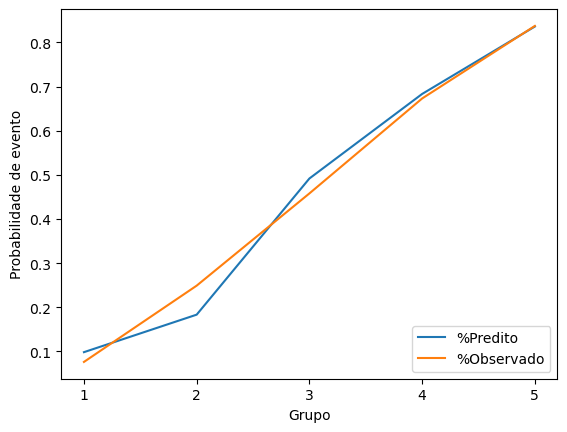

In [139]:
# - Comparando graficamente o valor eperado versus observado para a taxa de maus por grupo

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax = qualid['taxa_eventos'].plot(label='%Predito')
ax = qualid['predito'].plot(label='%Observado')

ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])
ax.legend(loc="lower right")
ax.set_ylabel('Probabilidade de evento')
ax.set_xlabel('Grupo')

5. Avaliando o modelo quanto a discriminação calculando acurácia, GINI e KS.

In [140]:
# Avaliando modelo
reglog = smf.logit(" flag_doente ~ sex + cp + trestbps + age"
                   , data=df).fit()

df['predito'] = reglog.predict(df)

avaliar_modelo(df['flag_doente'], df['predito'])

Optimization terminated successfully.
         Current function value: 0.510076
         Iterations 6
Acurácia: 77.89%
KS: 58.40% 
AUC: 83.11% 
GINI: 66.22%


6. tentando melhorar o modelo obtido, inserindo ou removendo variáveis.  
    Avaliando as características do modelo (calibragem e acurácia).

In [141]:
# Tentando melhorar o modelo
reglog = smf.logit(" flag_doente ~ sex + cp + age + thal + ca + slope"
                   , data=df).fit()

df['predito'] = reglog.predict(df)

avaliar_modelo(df['flag_doente'], df['predito']) 

Optimization terminated successfully.
         Current function value: 0.375525
         Iterations 7
Acurácia: 85.15%
KS: 70.76% 
AUC: 91.12% 
GINI: 82.24%
